In [20]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# DGP related methods
import sys
sys.path.append('../..')

from dsvidgp.kernels import RBF
from dsvidgp.likelihoods import Gaussian
from dsvidgp.layers import SVGPLayer

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [26]:
DATA_SIZE = 50
MINIBATCH_SIZE = 10

## Make data

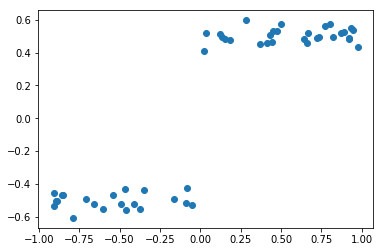

In [66]:
np.random.seed(811)
dx = np.random.rand(DATA_SIZE, 1).astype(np.float32) * 2.0 - 1.0
dy = np.where(dx + 0.04 * np.random.randn(*dx.shape) >= 0.0, 0.5, -0.5) \
        + 0.04 * np.random.randn(*dx.shape)
dy = dy.astype(np.float32)

nx = np.linspace(-1.0, 1.0, 200)[:, None]

plt.plot(dx, dy, 'o')

In [32]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dx, dy):

        self._N = len(dx)
        self._dx = dx
        self._dy = dy
        
    def __len__(self):
        return self._N
    
    def __getitem__(self, idx):
        return self._dx[idx], self._dy[idx]
    
dataset = Dataset(dx, dy)
dataloader = data.DataLoader(dataset, batch_size=MINIBATCH_SIZE, shuffle=True)


## Training method

In [62]:
def train(optimizer, model, num_epochs=1000):
    lower_bound_list = list()
    pred_mean_list = list()

    tx = torch.from_numpy(nx.astype(np.float32))

    pred_dstr = model.predict(tx.to(device))
    pred_mean_list.append(pred_dstr['mean'].data.cpu().numpy().copy())

    from ipywidgets import FloatProgress
    from IPython.display import display

    fp = FloatProgress(min=0, max=num_epochs)
    display(fp)

    for i in range(num_epochs):
        fp.value = i
        lower_bound = 0
        
        model.train()
        for b, (x_B, y_B) in enumerate(dataloader):
            x_B = x_B.to(device)
            y_B = y_B.to(device)

            optimizer.zero_grad()

            f_dstr = model(x_B)
            batch_bound = model.calc_bound(y_B, f_dstr)

            loss = -batch_bound  # maximize
            loss.backward()
            
            optimizer.step()

            lower_bound += batch_bound.data.cpu().item()

        lower_bound_list.append(lower_bound)

        model.eval()
        pred_dstr = model.predict(tx.to(device))
        pred_mean_list.append(pred_dstr['mean'].data.cpu().numpy().copy())

    return lower_bound_list, pred_mean_list


In [69]:
class DGP3(torch.nn.Module):
    """3-layer deep Gaussian process model."""
    
    def __init__(self, z0, data_size):
        super().__init__()
    
        # layer 1
        kern1 = RBF(input_dim=1, initial_lengthscale=0.2)
        self.layer1 = SVGPLayer(kern1, input_dim=1, output_dim=3,
                                                   initial_inducing_input=z0, initial_q_S_value=0.01, fix_inducing=False)

        # define function, which copies 1-dim value to 1st dimension.
        lin = torch.zeros((1, 3))
        lin[:, 0] = 1.0
        self.mean_func1 = lambda x: torch.mm(x, lin)
        
        # layer 2
        kern2 = RBF(input_dim=3, initial_lengthscale=1.0)
        self.layer2 = SVGPLayer(kern2, input_dim=3, output_dim=3,
                                                   num_inducings=10, initial_q_S_value=0.01, fix_inducing=True)
        self.mean_func2 = lambda x: x
        
        # layer 3
        kern3 = RBF(input_dim=3, initial_lengthscale=1.0)
        self.layer3 = SVGPLayer(kern3, input_dim=3, output_dim=1,
                                            num_inducings=10, initial_q_S_value=1.0, fix_inducing=True)

        # output
        self.likelihood = Gaussian(output_dim=1, initial_variance=1e-3)

        self.layers = [self.layer1, self.layer2, self.layer3]
        self.data_size = data_size

    def forward(self, x):
        h1 = self.mean_func1(x) + self.layer1(x)
        h2 = self.mean_func2(h1) + self.layer2(h1)

        return self.layer3.pred_mean_and_var(h2)
    
    def calc_bound(self, y, f_dstr):
        pe = self.likelihood.predictive_expectation(y, f_dstr)
        
        kld = sum(layer.kl_divergence() for layer in self.layers)
        
        batch_size = y.size(0)
        bound = pe  - batch_size / self.data_size * kld
        
        return bound
     
    def predict(self, x):
        f_dstr = self.forward(x)

        y_dstr = self.likelihood.predict(f_dstr)
        return y_dstr


def make_dgp3():
    z0 = np.linspace(-1.0, 1.0, 10)[:, None]  # num_inducings = 10
    
    model = DGP3(z0, len(dx))
    
    return model

model = make_dgp3()
model.state_dict()


OrderedDict([('layer1.q_diag_S_', tensor([[-4.6003, -4.6003, -4.6003],
                      [-4.6003, -4.6003, -4.6003],
                      [-4.6003, -4.6003, -4.6003],
                      [-4.6003, -4.6003, -4.6003],
                      [-4.6003, -4.6003, -4.6003],
                      [-4.6003, -4.6003, -4.6003],
                      [-4.6003, -4.6003, -4.6003],
                      [-4.6003, -4.6003, -4.6003],
                      [-4.6003, -4.6003, -4.6003],
                      [-4.6003, -4.6003, -4.6003]])),
             ('layer1.q_mu', tensor([[0., 0., 0.],
                      [0., 0., 0.],
                      [0., 0., 0.],
                      [0., 0., 0.],
                      [0., 0., 0.],
                      [0., 0., 0.],
                      [0., 0., 0.],
                      [0., 0., 0.],
                      [0., 0., 0.],
                      [0., 0., 0.]])),
             ('layer1.z', tensor([[-1.0000],
                      [-0.7778],
           

In [70]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
lower_bound_list, pred_mean_list = train(optimizer, model, num_epochs=1000)

FloatProgress(value=0.0, max=1000.0)

## Results

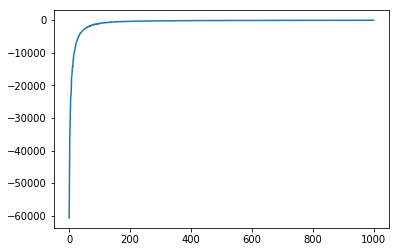

In [71]:
# plotting the change of ELBO
plt.plot(lower_bound_list)

### plot predicted mean for each epoch

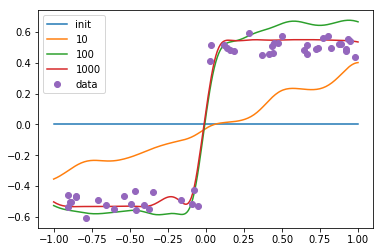

In [72]:
plt.plot(nx, pred_mean_list[0], label='init')
for j in [10, 100, 1000]:
    if j < len(pred_mean_list):
        plt.plot(nx, pred_mean_list[j], label=str(j))
plt.plot(dx, dy, 'o', label='data')
plt.legend()

## plot layer-wise value

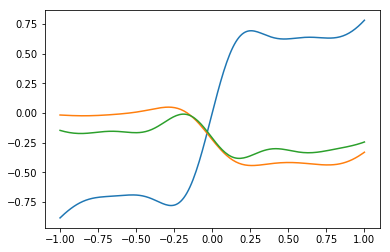

In [75]:
tx = torch.from_numpy(nx.astype(np.float32))
m1 = model.mean_func1(tx) + model.layer1.pred_mean_and_var(tx)['mean']
plt.plot(nx, m1.data.numpy())

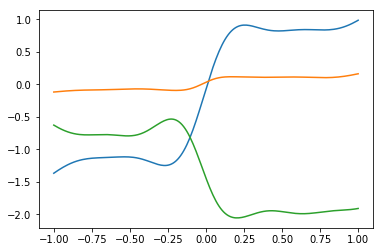

In [76]:
m2 = model.mean_func2(m1) + model.layer2.pred_mean_and_var(m1)['mean']
plt.plot(nx, m2.data.numpy())

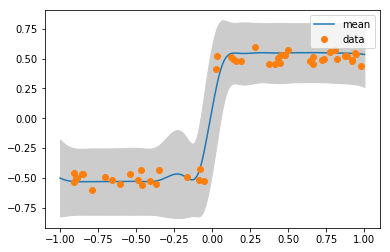

In [89]:
f_dstr =model.layer3.pred_mean_and_var(m2)
y_dstr = model.likelihood.predict(f_dstr)
m_y = y_dstr['mean'].data.numpy()
s_y = np.sqrt(y_dstr['var'].data.numpy())
plt.fill_between(nx.ravel(), (m_y + 2 * s_y).ravel(), (m_y - 2 * s_y).ravel(), color='#cccccc')
plt.plot(nx, m_y, label='mean')
plt.plot(dx, dy, 'o', label='data')
plt.legend()